In [2]:
import numpy as np
import scipy
import scipy.ndimage as nd
import pylab as pl
%pylab inline
import os
from matplotlib import colors


/Users/ianstuart/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Populating the interactive namespace from numpy and matplotlib


### Reading in the image data

In [3]:
# put all images in a list

images_path = 'skynet-data/data/images/'
images_files = os.listdir(images_path)

images = []
for f in images_files:
    file_path = images_path + f
    images.append(nd.imread(file_path))

shape(images)

(15, 256, 256, 3)

In [4]:
# put all labels in a list
# select only the labels that have a corresponding image

labels_path = 'skynet-data/data/labels/color/'
labels_files = os.listdir(labels_path)

labels = []
for f in labels_files:
    if f in images_files:
        file_path = labels_path + f
        labels.append(nd.imread(file_path))

shape(labels)

(15, 256, 256, 3)

In [5]:
classes = np.unique(labels)
classes

array([  0, 255], dtype=uint8)

### Image segmentation

In [6]:
from skimage import exposure
from skimage import segmentation as sg

In [7]:
len(images)

15

Number of segments: 97


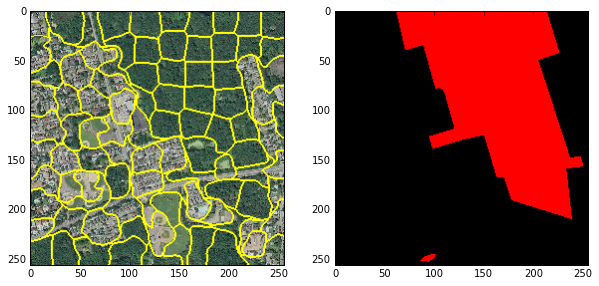

In [8]:
# example segmentation with corresponding labels

for i, image in enumerate(images):
    img = images[i]
    lbl = labels[i]    

    fig = plt.figure(figsize=(10,5))
    subplot = 121

    segments = sg.slic(img, n_segments = 100, sigma = 4)
    ax = fig.add_subplot(subplot)
    ax.imshow(sg.mark_boundaries(img, segments))
    subplot += 1

    ax = fig.add_subplot(subplot)
    ax.imshow(lbl)

    n_segments = len(np.unique(segments))
    print('Number of segments: ' + str(n_segments))
    break

In [9]:
segments = []
offset = 0

# ~1000 segments per image

for i, image in enumerate(images):
    segments.append(sg.slic(image, n_segments = 1000, sigma = 4))
    segments[i] = segments[i] + offset   
    offset += len(np.unique(segments[i]))
        
n_segments = len(np.unique(segments))
print(str(n_segments) + ' segments in ' + str(len(images)) + ' images')
# print shape(segments)

15358 segments in 15 images


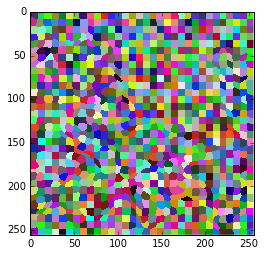

In [10]:
from matplotlib import colors

# show segments for the first image 

cmap = colors.ListedColormap(np.random.rand(len(np.unique(segments[0])), 3))
plt.figure()
plt.imshow(segments[0], interpolation='none', cmap=cmap)

### Creating the training data from the segments

In [11]:
# only the red band matters in the labels

labels2d = []

for i in range(len(labels)):
    labels2d.append(labels[i][:,:,0])

shape(labels2d)

(15, 256, 256)

In [12]:
train_images = images[:10]
test_images = images[10:]

train_labels = labels2d[:10]
test_labels = labels2d[10:]

In [39]:
# # get number of segments in each of the two classes, for single image

# segments_per_klass = {}

# for klass in classes:
#     segments_of_klass = segments[0][labels2d==klass]
#     segments_per_klass[klass] = set(segments_of_klass)
#     print("Training segments for class %i: %i" % (klass, len(segments_per_klass[klass])))

In [13]:
# get number of segments in each of the two classes, for each image

# this will give us a nested dict with keys for each segmented image

all_img_segments = {}

for i, label in enumerate(labels2d):
    segments_per_klass = {}
    for klass in classes:
        segments_of_klass = segments[i][label==klass]
        segments_per_klass[klass] = set(segments_of_klass)
#         print("Training segments for class %i: %i" % (klass, len(segments_per_klass[klass])))
    all_img_segments[i] = segments_per_klass

In [14]:
# create a 'model' for each training segment (get stats, or features, for each band)

def segment_features(segment_pixels):
    """
    For each band, compute: min, max, mean, variance, skewness, kurtosis.
    """
    features = []
    _, n_bands = segment_pixels.shape

    for b in range(n_bands):
        stats = scipy.stats.describe(segment_pixels[:,b])
        band_stats = list(stats.minmax) + list(stats)[2:]
        features += band_stats
    return features

In [18]:
segment_ids = np.unique(segments)
len(segment_ids)

15358

In [19]:
shape(images[0])
# shape(segments)
# shape(segments==segment_label)

(256, 256, 3)

In [20]:
# create 'features vector' for each segment id in training data using descriptive stats

all_objects = []
all_objects_ids = []

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    for i, img in enumerate(images):
        objects = []
        objects_ids = []
        for segment_label in segment_ids:
            segment_pixels = img[segments[i]==segment_label]
            if (len(segment_pixels) > 0):
                segment_model = segment_features(segment_pixels)
                objects.append(segment_model)
                # Keep a reference to the segment label
                objects_ids.append(segment_label)  
        all_objects.append(objects)
        all_objects_ids.append(objects_ids)
        
#         print("Created %i objects" % len(objects))

len(all_objects)

15

In [57]:
# len(train_objects[0])
# len(train_objects_ids[0])
# len(train_objects_ids)

In [21]:
train_img_segments = {}

for k in all_img_segments.keys()[:10]:
    train_img_segments[k] = all_img_segments[k]

len(train_img_segments)

10

In [22]:
# all_img_segments[:10]

In [35]:
# print len(train_images), len(train_objects), len(train_objects_ids), len(train_img_segments)

training_labels = []
training_objects = []

for j in range(len(train_images)):
    for klass in classes:
        class_train_objects = [v for i, v in enumerate(all_objects[j]) if all_objects_ids[j][i] in train_img_segments[j][klass]]
        training_labels += [klass] * len(class_train_objects)
        print("Training samples for class %i: %i" % (klass, len(class_train_objects)))
        training_objects += class_train_objects

shape(training_labels)
shape(training_objects)

Training samples for class 0: 729
Training samples for class 255: 379
Training samples for class 0: 320
Training samples for class 255: 835
Training samples for class 0: 937
Training samples for class 255: 242
Training samples for class 0: 967
Training samples for class 255: 173
Training samples for class 0: 822
Training samples for class 255: 257
Training samples for class 0: 1009
Training samples for class 255: 60
Training samples for class 0: 700
Training samples for class 255: 394
Training samples for class 0: 1023
Training samples for class 255: 2
Training samples for class 0: 865
Training samples for class 255: 220
Training samples for class 0: 1024
Training samples for class 255: 4


(10962, 18)

In [70]:
from sklearn.ensemble import RandomForestClassifier

for i in range(1,50,2):
    classifier = RandomForestClassifier(n_estimators=i, n_jobs=-1, oob_score=True)
    classifier.fit(training_objects, training_labels)
    print classifier.oob_score_

0.769567597154
0.77650063857
0.776226965882
0.784163473819
0.79155263638
0.791370187922
0.793194672505
0.792099981755
0.793377120963
0.791735084839
0.797573435504
0.795384054005
0.794015690567
0.796022623609
0.793559569422
0.796569968984
0.795566502463
0.7991242474
0.795110381317
0.798576902025
0.794471811713
0.796296296296
0.7969348659
0.79593139938
0.796387520525


In [73]:
# oob score levels off after 10 estimaters, so we will leave this at the default
# looking at cross validation score

from sklearn.cross_validation import cross_val_score

for i in range(1,50,2):
    classifier = RandomForestClassifier(n_estimators=i, n_jobs=-1)
    classifier.fit(training_objects, training_labels)
    print np.mean(cross_val_score(classifier, training_objects, training_labels, cv=10))


0.742134338982
0.761198952727
0.762929450598
0.764027172488
0.766580587156
0.768862193696
0.769409472909
0.768038111412
0.772144370492
0.771690912951
0.772057708237
0.769045341592
0.770780334911
0.772781308925
0.768952685406
0.770958321366
0.77123395895
0.77032254842
0.772694813168
0.769503128083
0.771781571159
0.773149602694
0.773423408799
0.769865094925
0.771874060847


In [ ]:
# CV score also levels off, 10 estimators looks fine

In [25]:
classifier.fit(training_objects, training_labels)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=-1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [27]:
shape(all_objects[0])

(1024, 18)

In [29]:
predicted = []

for i in range(len(images)):
    predicted.append(classifier.predict(all_objects[i]))
#     print np.unique(predicted[i])

In [30]:
clf = np.copy(segments[0])

In [31]:
for segment_id, klass in zip(all_objects_ids[0], predicted[0]):
    clf[clf==segment_id] = klass
np.unique(clf)

array([  0, 255])

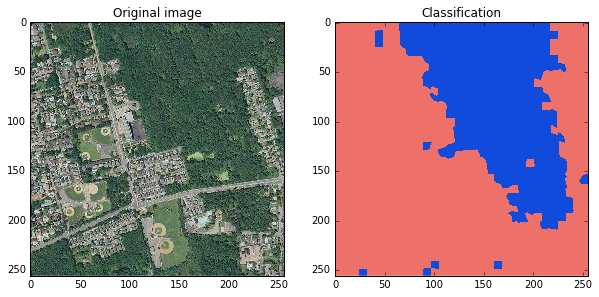

In [32]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,20))
ax1.imshow(images[0], interpolation='none')
ax1.set_title('Original image')
ax2.imshow(clf, interpolation='none', cmap=colors.ListedColormap(np.random.rand(len(classes), 3)))
ax2.set_title('Classification')

### Try it on test images

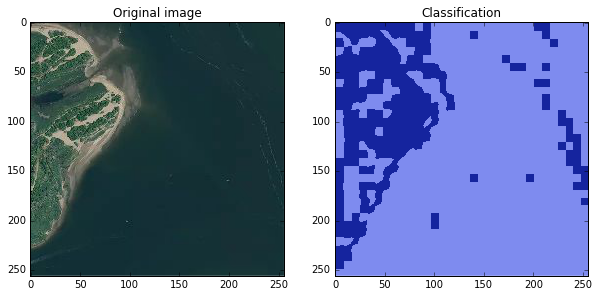

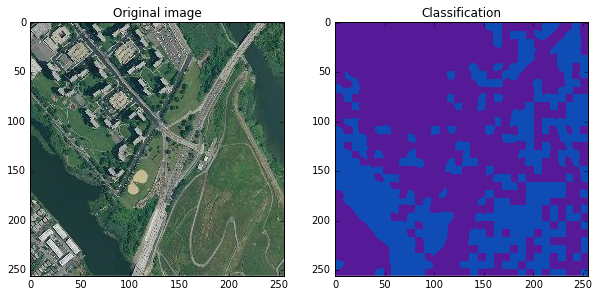

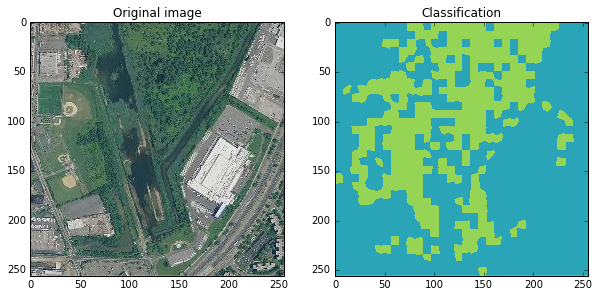

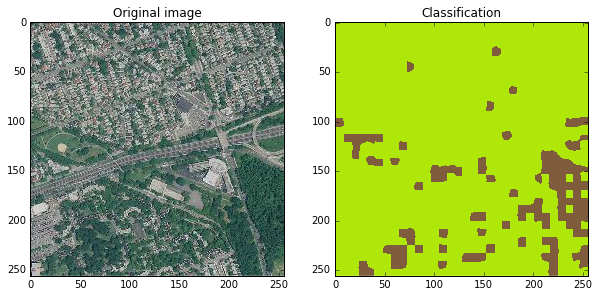

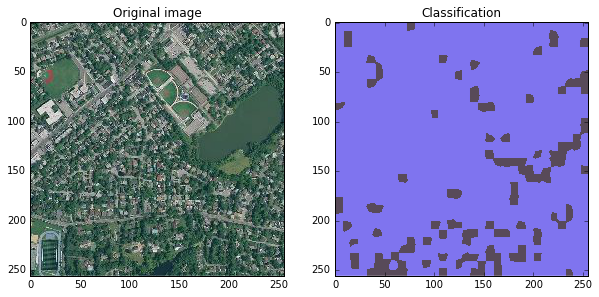

In [45]:
pred_labels = []
for i in range(10, 10 + len(test_images)):
    clf = np.copy(segments[i])
    for segment_id, klass in zip(all_objects_ids[i], predicted[i]):
        clf[clf==segment_id] = klass
        pred_labels.append(clf)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,20))
    ax1.imshow(images[i], interpolation='none')
    ax1.set_title('Original image')
    ax2.imshow(clf, interpolation='none', cmap=colors.ListedColormap(np.random.rand(len(classes), 3)))
    ax2.set_title('Classification')

In [67]:
from sklearn import metrics

for_verification = np.nonzero(test_labels[2])
# shape(for_verification)
# for_verification[0]
verification_labels = test_labels[2][for_verification]
predicted_labels = pred_labels[2][for_verification]

# # shape(verification_labels)
cmatrix = metrics.confusion_matrix(verification_labels, predicted_labels)

array([  0,   0,   0, ..., 248, 248, 248])

In [63]:
cmatrix

array([[   0,    0],
       [1122, 1791]])

In [64]:
print("Classification accuracy: %f" %
      metrics.accuracy_score(verification_labels, predicted_labels))

Classification accuracy: 0.614830


In [65]:
print("Classification report:\n%s" %
      metrics.classification_report(verification_labels, predicted_labels))

Classification report:
             precision    recall  f1-score   support

          0       0.00      0.00      0.00         0
        255       1.00      0.61      0.76      2913

avg / total       1.00      0.61      0.76      2913

